# Upscale GEDI biomass with PALSAR-2 backscatter

This practical will take the GEDI data we used in the last notebook, overlay it with PALSAR data and look for a relationship between the two. First we will load GEDI data into RAM using the same method as the last notebook.

In [1]:
# import libraries
import numpy as np
from sys import path
path.append("/geos/netdata/active_sensing/code_active/10_upscaling")
from gediL4Areader import gediL4A,dataTable

# define a filename
gediName='/Users/dougal/data/teaching/active_sensing/10_fusion/gedi/L4A/subset.GEDI04_A_2020178113837_O08714_02_T00308_02_002_02_V002.h5'

# read the data
gedi=gediL4A(gediName)

# filter out poor quality data
gedi.filterQuality()

Found 97329 footprints
Filtered 68206 from 97329


Now load the PALSAR data and check that it looks sensible. The files are large and this may take a minute.

In [2]:
# import libraries
import rasterio
import matplotlib.pyplot as plt

# open the two files
palsarHHname='/Users/dougal/data/teaching/active_sensing/10_fusion/palsar/merged_HH.tif'
palsarHVname='/Users/dougal/data/teaching/active_sensing/10_fusion/palsar/merged_HV.tif'
palsarHH=rasterio.open(palsarHHname)
palsarHV=rasterio.open(palsarHVname)

# read the raster layers
hh=palsarHH.read(1)
hv=palsarHV.read(1)

# plot to the screen for sanity check
#plt.imshow(hh)
#plt.title('HH')
#plt.show()

#plt.imshow(hv)
#plt.title('HV')
#plt.show()


We have points of AGBD estimates from GEDI and a raster of backscatter from PALSAR-2. Is there a useful relationship between one and the other? To test this we need to make a table of GEDI AGBD values and backscatter from the corresponding PALSAR-2 pixels.

Run the code below to make a plot and determine the linear correlation.

[11934 11936 11938 ... 26939 26942 26951] [17999 17998 17996 ...  7815  7813  7807]


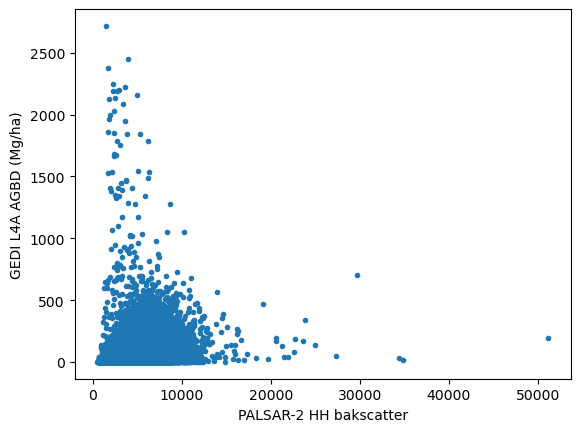

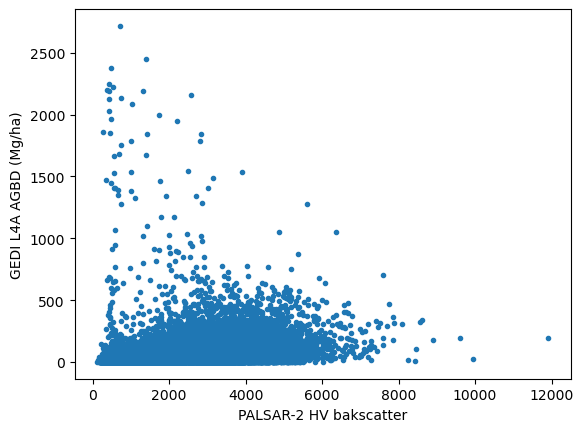

In [3]:
# make a table from the two datasets
mergedData=dataTable(gedi,palsarHH,hh,palsarHV,hv)

# plot that table up
mergedData.plotHH()
mergedData.plotHV()

# determine linear correlation